## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint

# Disable GPU
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation='relu', 
                                   name='hidden_layer'+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation='relu', 
                                   name='hidden_layer'+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

reduce_lr_factor = [0.5, 0.1]
redice_lr_patient = [5, 10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normaliz

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 14s 271us/step - loss: 2.3157 - acc: 0.2424 - val_loss: 2.1936 - val_acc: 0.2937
Epoch 2/25
50000/50000 [==============================] - 8s 166us/step - loss: 1.8612 - acc: 0.3549 - val_loss: 1.9066 - val_acc: 0.3546
Epoch 3/25
50000/50000 [==============================] - 8s 164us/step - loss: 1.7268 - acc: 0.4001 - val_loss: 1.7886 - val_acc: 0.3801
Epoch 4/25
50000/50000 [==============================] - 8s 165us/step - loss: 1.6514 - acc: 0.4239 - val_loss: 1.7247 - val_acc: 0.4038
Epoch 5/25
50000/50000 [==============================] - 8s 165us/step - loss: 1.5966 - acc: 0.4431 - val_loss: 1.6805 - val_acc: 0.4129
Epoch 6/25
50000/50000 [==============================] - 8s 167us/step - loss: 1.5537 - acc: 0.4587 - val_loss: 1.6497 - val_acc: 0.4209
Epoch 7/25
50000/50000 [==============================] - 8s 165us/step - loss: 1.5175 - acc: 0.4719 - val_loss: 1.6258 -

Epoch 24/25
50000/50000 [==============================] - 8s 164us/step - loss: 1.1742 - acc: 0.5984 - val_loss: 1.4859 - val_acc: 0.4789
Epoch 25/25
50000/50000 [==============================] - 8s 164us/step - loss: 1.1588 - acc: 0.6029 - val_loss: 1.4877 - val_acc: 0.4797
Numbers of exp: 3, reduce_factor: 0.10, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
bat

Epoch 11/25
50000/50000 [==============================] - 10s 194us/step - loss: 0.8906 - acc: 0.6928 - val_loss: 1.6871 - val_acc: 0.4331
Epoch 12/25
50000/50000 [==============================] - 9s 183us/step - loss: 0.8580 - acc: 0.7058 - val_loss: 1.6676 - val_acc: 0.4359
Epoch 13/25
50000/50000 [==============================] - 10s 190us/step - loss: 0.8222 - acc: 0.7190 - val_loss: 1.5214 - val_acc: 0.4843
Epoch 14/25
50000/50000 [==============================] - 9s 185us/step - loss: 0.7858 - acc: 0.7320 - val_loss: 1.4969 - val_acc: 0.4871
Epoch 15/25
50000/50000 [==============================] - 9s 183us/step - loss: 0.7530 - acc: 0.7435 - val_loss: 1.6192 - val_acc: 0.4604
Epoch 16/25
50000/50000 [==============================] - 9s 187us/step - loss: 0.7159 - acc: 0.7573 - val_loss: 1.6022 - val_acc: 0.4798
Epoch 17/25
50000/50000 [==============================] - 9s 186us/step - loss: 0.6862 - acc: 0.7672 - val_loss: 1.6602 - val_acc: 0.4651
Epoch 18/25
50000/50000 [

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 17s 333us/step - loss: 1.8336 - acc: 0.3695 - val_loss: 1.8471 - val_acc: 0.3655
Epoch 2/25
50000/50000 [==============================] - 9s 187us/step - loss: 1.5178 - acc: 0.4674 - val_loss: 1.5981 - val_acc: 0.4388
Epoch 3/25
50000/50000 [==============================] - 9s 186us/step - loss: 1.4198 - acc: 0.5067 - val_loss: 1.5781 - val_acc: 0.4436
Epoch 4/25
50000/50000 [==============================] - 9s 186us/step - loss: 1.3512 - acc: 0.5314 - val_loss: 1.5531 - val_acc: 0.4575
Epoch 5/25
50000/50000 [==============================] - 10s 195us/step - loss: 1.2940 - acc: 0.5507 - val_loss: 1.5120 - val_acc: 0.4692
Epoch 6/25
50000/50000 [==============================] - 9s 188us/step - loss: 1.2465 - acc: 0.5674 - val_loss: 1.4743 - val_acc: 0.4852
Epoch 7/25
50000/50000 [==============================] - 9s 186us/step - loss: 1.2012 - acc: 0.5855 - val_loss: 1.4512 

50000/50000 [==============================] - 9s 184us/step - loss: 2.6717 - acc: 0.1482 - val_loss: 2.6661 - val_acc: 0.1538
Epoch 23/25
50000/50000 [==============================] - 9s 183us/step - loss: 2.6651 - acc: 0.1495 - val_loss: 2.6592 - val_acc: 0.1552
Epoch 24/25
50000/50000 [==============================] - 9s 187us/step - loss: 2.6577 - acc: 0.1502 - val_loss: 2.6524 - val_acc: 0.1563
Epoch 25/25
50000/50000 [==============================] - 9s 184us/step - loss: 2.6518 - acc: 0.1512 - val_loss: 2.6458 - val_acc: 0.1577
Numbers of exp: 8, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
ba

50000/50000 [==============================] - 9s 171us/step - loss: 1.1630 - acc: 0.5963 - val_loss: 2.1032 - val_acc: 0.3375
Epoch 9/25
50000/50000 [==============================] - 9s 173us/step - loss: 1.1259 - acc: 0.6077 - val_loss: 2.0301 - val_acc: 0.3699
Epoch 10/25
50000/50000 [==============================] - 9s 171us/step - loss: 1.0860 - acc: 0.6233 - val_loss: 1.8501 - val_acc: 0.3862
Epoch 11/25
50000/50000 [==============================] - 9s 172us/step - loss: 1.0514 - acc: 0.6381 - val_loss: 1.6296 - val_acc: 0.4383
Epoch 12/25
50000/50000 [==============================] - 9s 172us/step - loss: 1.0170 - acc: 0.6489 - val_loss: 1.7999 - val_acc: 0.3865
Epoch 13/25
50000/50000 [==============================] - 9s 171us/step - loss: 0.9875 - acc: 0.6608 - val_loss: 1.7666 - val_acc: 0.4146
Epoch 14/25
50000/50000 [==============================] - 9s 171us/step - loss: 0.9507 - acc: 0.6735 - val_loss: 1.8038 - val_acc: 0.4204
Epoch 15/25
50000/50000 [===============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 16s 330us/step - loss: 2.2631 - acc: 0.2535 - val_loss: 2.1586 - val_acc: 0.2925
Epoch 2/25
50000/50000 [==============================] - 9s 171us/step - loss: 1.9064 - acc: 0.3438 - val_loss: 1.9507 - val_acc: 0.3406
Epoch 3/25
50000/50000 [==============================] - 9s 171us/step - loss: 1.7660 - acc: 0.3863 - val_loss: 1.8461 - val_acc: 0.3730
Epoch 4/25
50000/50000 [==============================] - 9s 173us/step - loss: 1.6781 - acc: 0.4148 - val_loss: 1.7738 - val_acc: 0.3897
Epoch 5/25
50000/50000 [==============================] - 9s 174us/step - loss: 1.6141 - acc: 0.4366 - val_loss: 1.7182 - val_acc: 0.4092
Epoch 6/25
50000/50000 [==============================] - 9s 171us/step - loss: 1.5621 - acc: 0.4544 - val_loss: 1.6854 - val_acc: 0.4142
Epoch 7/25
50000/50000 [==============================] - 9s 173us/step - loss: 1.5190 - acc: 0.4722 - val_loss: 1.6482 -

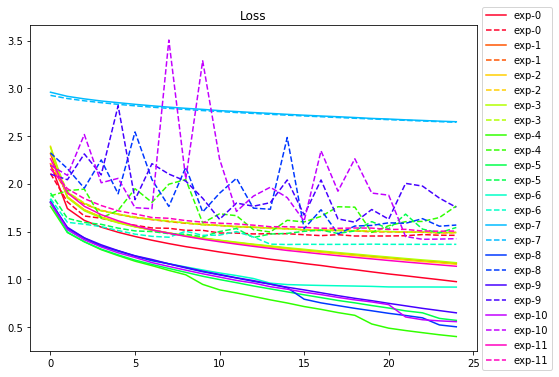

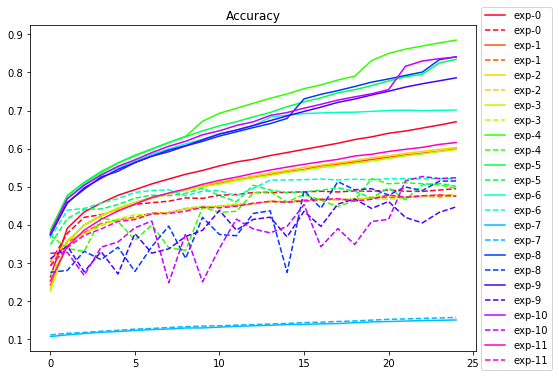

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()